In [92]:
import datetime
import itertools
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import json

with open('vars.json') as f:
    data = json.load(f)
    
FUSIONAUTH_TOKEN = data['FUSIONAUTH_TOKEN']
FUSIONAUTH_DOMAIN = data['FUSIONAUTH_DOMAIN']

In [95]:
conn = sqlite3.connect('data/database.db')
df_answers = pd.read_sql_query('SELECT * FROM answers', conn, dtype={'question_id': int}, parse_dates=['ask_time', 'answer_time'])
df_questions = pd.read_sql_query('SELECT * FROM questions', conn)
df_groups = pd.read_sql_query('SELECT * FROM question_to_group', conn)

In [96]:
def plot_distribution():
    merged_df = pd.merge(df_answers, df_questions, left_on='question_id', right_on='id', suffixes=('_answer', '_question'))
    pivot_table = merged_df.pivot_table(index='level', columns='question_id', aggfunc='size', fill_value=0)
    
    plt.figure(figsize=(10, pivot_table.index.max()))
    sns.heatmap(pivot_table, cmap='Greys', annot=True, fmt='d')
    plt.title('Distribution of Answer Levels')
    plt.xlabel('Question ID')
    plt.ylabel('Question Level')
    plt.show()

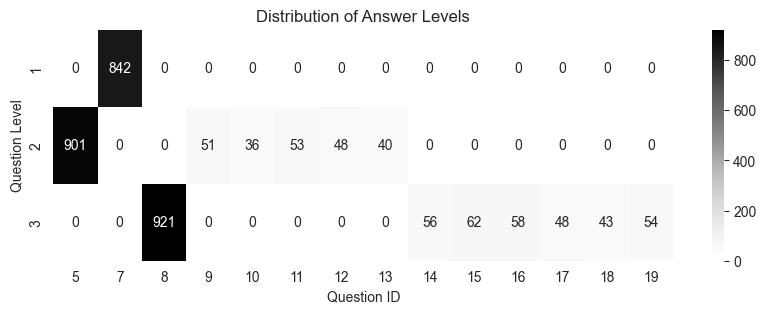

In [97]:
plot_distribution()

In [98]:
def plot_distribution(person_id):
    
    resp = requests.get(f"{FUSIONAUTH_DOMAIN}/api/user/{person_id}", headers={"Authorization": FUSIONAUTH_TOKEN})
    resp = resp.json()['user']
    all_groups = [m["groupId"] for m in resp["memberships"]]
    if "groupLevels" in resp["data"]:
        person_groups = [(item["groupId"], item["level"]) for item in resp["data"]["groupLevels"] if item["groupId"] in all_groups]
    
    possible_questions = []
    for group, level in person_groups:
        possible_questions.extend(df_groups[df_groups.group_id == group].question_id.tolist()) 
    
    merged_df = pd.merge(df_answers, df_questions, left_on='question_id', right_on='id', suffixes=('_answer', '_question'))
    
    pivot_table = merged_df.where(merged_df.person_id == person_id).where(merged_df.question_id.isin(possible_questions)).pivot_table(index='level', columns='question_id', aggfunc='size', fill_value=0)

    plt.figure(figsize=(10, pivot_table.index.max()))
    sns.heatmap(pivot_table, cmap='Greys', annot=True, fmt='d')
    plt.title(f'Distribution of Answer Levels')
    plt.xlabel('Question ID')
    plt.ylabel('Question Level')
    plt.show()

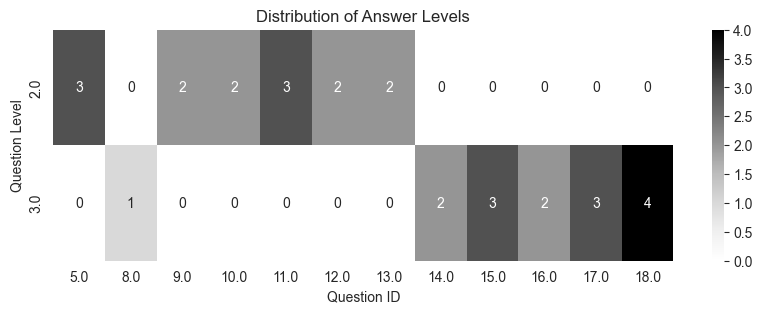

In [99]:
plot_distribution("605f38fb-b25b-4082-9b17-199c4d3685a2")

In [100]:
def plot_questions_frequency(person_id):
    resp = requests.get(f"{FUSIONAUTH_DOMAIN}/api/user/{person_id}", headers={"Authorization": FUSIONAUTH_TOKEN})
    resp = resp.json()['user']
    all_groups = [m["groupId"] for m in resp["memberships"]]
    person_groups = []

    if "groupLevels" in resp["data"]:
        person_groups = [(item["groupId"], item["level"]) for item in resp["data"]["groupLevels"] if item["groupId"] in all_groups]
    
    possible_questions = []
    for group, level in person_groups:
        possible_questions.extend(df_groups[df_groups.group_id == group].question_id.tolist()) 
    
    merged_df = pd.merge(df_answers, df_questions, left_on='question_id', right_on='id', suffixes=('_answer', '_question'))
    pivot_table = merged_df.where(merged_df.person_id == person_id).where(merged_df.question_id.isin(possible_questions)).pivot_table(index='question_id', aggfunc='size', fill_value=0)

    plt.figure(figsize=(10, 6))
    sns.barplot(pivot_table)
    plt.title('Distribution of Answer Levels')
    plt.xlabel('Question ID')
    plt.ylabel('Frequency of answers')
    plt.show()

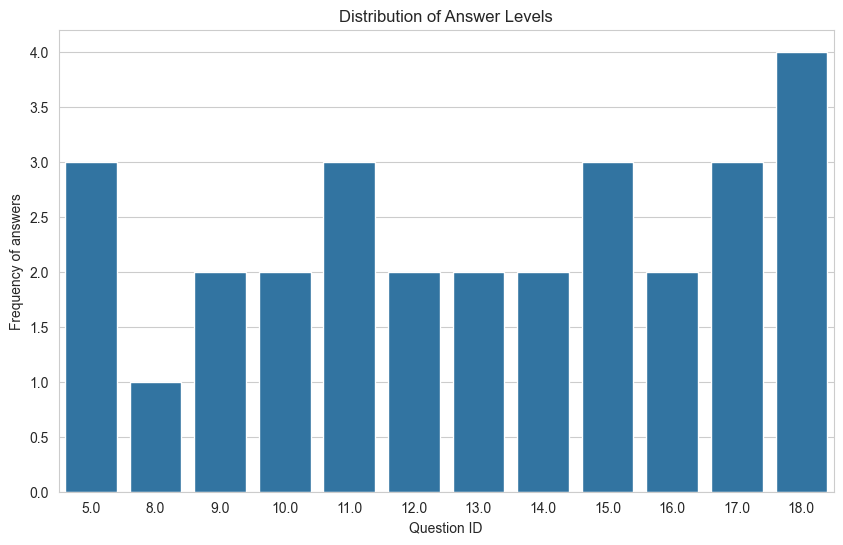

In [101]:
plot_questions_frequency("605f38fb-b25b-4082-9b17-199c4d3685a2")

In [208]:
def plot_answers_time_relation(person_id,):
    merged_df = pd.merge(df_answers, df_questions, left_on='question_id', right_on='id', suffixes=('_answer', '_question'))
    merged_df = merged_df.where(merged_df.person_id == person_id)
    
    plt.figure(figsize=(10, 4))
    sns.jointplot(merged_df, x='ask_time', y='question_id', hue='level')
    plt.show()

<Figure size 3000x1200 with 0 Axes>

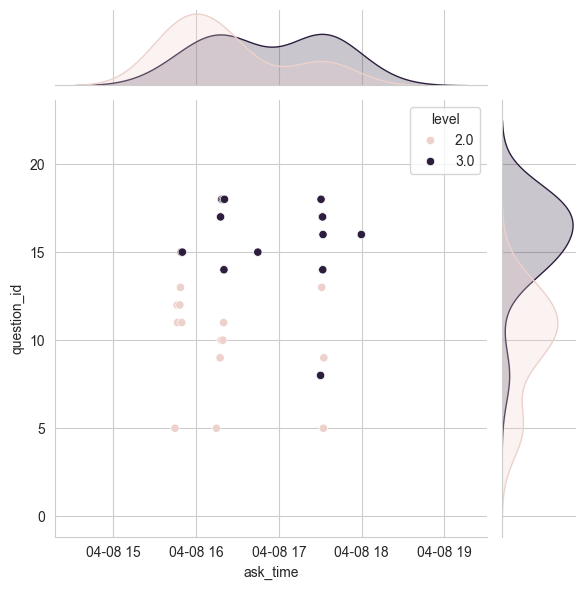

In [209]:
plot_answers_time_relation('605f38fb-b25b-4082-9b17-199c4d3685a2')